In [1]:
import SimpleITK as sitk
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import six

import radiomics
from radiomics import firstorder, imageoperations

## Data Setup and Loading

In [2]:
tumor_dir = "/media/katy/Data/ICC/Data/All_CT/Tumor"
all_tumor_files = os.listdir(tumor_dir)
tumor_files_mhd = [x for x in all_tumor_files if "mhd" in x]
tumor_files_mhd.sort()

liver_dir = "/media/katy/Data/ICC/Data/All_CT/Liver"
all_liver_files = os.listdir(liver_dir)
liver_files_mhd = [y for y in all_liver_files if "mhd" in y]
liver_files_mhd.sort()

print("Tumor file count: ", len(tumor_files_mhd))
print("Liver file count: ", len(liver_files_mhd))

Tumor file count:  496
Liver file count:  496


In [3]:
cancer_type = "HCC_MCRC_ICC"
lbl_file_name = "/media/katy/Data/ICC/HDFS/Labels/" + cancer_type + "_HDFS_labels.xlsx"
liver_labels = pd.read_excel(lbl_file_name)

# Dataframe to store features for each patient
liver_features_df = pd.DataFrame(columns=['ScoutID'])
tumor_features_df = pd.DataFrame(columns=['ScoutID'])

In [107]:
liver_labels

,ScoutID,HDFS_Time,HDFS_Code,Cancer_Type
0,001-hcc,26.000000,0,0
1,002-hcc,16.000000,1,0
2,003-hcc,6.000000,0,0
3,004-hcc,97.000000,0,0
4,005-hcc,6.000000,0,0
...,...,...,...,...
491,Erasmus_ICC-023,13.832001,1,2
492,Erasmus_ICC-028,36.436316,1,2
493,Erasmus_ICC-029,23.327127,1,2
494,Erasmus_ICC-036,21.585807,1,2


### Load image and create mask

In [6]:
idx = 320
liver_labels['ScoutID'][idx]


'010a_ICCradio'

In [7]:
idx = 320
scoutid = liver_labels['ScoutID'][idx]
scout_id = scoutid + "_"
print("Patient ", idx,": ", scout_id)
## DATA LOADING ##

tumor_files = [f for f in tumor_files_mhd if scout_id in f]
liver_file = [f for f in liver_files_mhd if scout_id in f]
# if len(tumor_file) != 1:
#     print(tumor_file)
#     raise Exception("scout_id should find 1 tumor file. Caught %i files.".format(len(tumor_file)))
if len(liver_file) != 1:
    print(liver_file)
    raise Exception("scout_id should find 1 liver file. Caught %i files.".format(len(liver_file)))

    
# Loading patient idx image
liver_file = liver_file[0]

# print("Tumor file: ", tumor_file)
# print("Liver file: ", liver_file)

# # Load tumor image
# tumor_img_path = os.path.join(tumor_dir, tumor_file)
# tumor_image = sitk.ReadImage(tumor_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)
# # Convert to array for mask making
# tumor_arr = sitk.GetArrayFromImage(tumor_image)

liver_img_path = os.path.join(liver_dir, liver_file)
liver_mhd_image = sitk.ReadImage(liver_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)
# Convert to array for mask making
liver_arr = sitk.GetArrayFromImage(liver_mhd_image)

if scout_id == "ICC_Radiogen_Add28_":
        del liver_mhd_image
        liver_arr = liver_arr[300:600,:,:]

# Initialize total tumor mask
total_tumor_mask = np.full(liver_arr.shape, False, dtype=bool)
for tfile in tumor_files:
    # Load tumor image
    tumor_img_path = os.path.join(tumor_dir, tfile)
    tumor_mhd_image = sitk.ReadImage(tumor_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)
    # Convert to array for mask making
    tumor_arr = sitk.GetArrayFromImage(tumor_mhd_image)

    # This one patient has too many slices and causes the program to run out of memory
    # So I select from 700 down to the 300 that have liver/tumor pixels with some boundary slices
    if scout_id == "ICC_Radiogen_Add28_":
        del tumor_mhd_image
        tumor_arr = tumor_arr[300:600,:,:]

    # Add this tumor to existing tumor mask
    tumor_mask = tumor_arr != -1000
    total_tumor_mask = np.bitwise_or(total_tumor_mask, tumor_mask)

Patient  320 :  010a_ICCradio_


In [164]:
# Second tumor used in figure for multi-tumor masking example
# tumor_img_path = os.path.join(tumor_dir, '006_recurrence_preop_Tumor 3.mhd')
# tumor_mhd_image = sitk.ReadImage(tumor_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)

# # Convert to array for mask making
# tumor_arr = sitk.GetArrayFromImage(tumor_mhd_image)

### Mask out tumor from liver image

In [8]:
## MASK MAKING ##
# Make masks for tumor and liver
# -1000 is background value in these images
# tumor_mask = tumor_arr != -1000
liver_mask = liver_arr != -1000
# Convert to numeric values for easy handling
tumor_mask = total_tumor_mask.astype(float)
liver_mask = liver_mask.astype(float)

# Remove tumor from liver image and mask
# Set tumor to 0s in tumor mask and remove from liver mask
notumor_livermask = liver_mask * (1 - tumor_mask)
# Set tumor to 0s in tumor mask, use to set to 0 in liver image, add -1000 to tumor to set as background
notumor_liver = liver_arr * (1 - tumor_mask) + (tumor_mask * -1000)

# plt.imshow(notumor_liver[12,:,:], cmap='gray')

### Confirming data loading and successful tumor masking

In [9]:
np.nonzero(tumor_mask)

(array([ 62,  62,  62, ..., 120, 120, 120]),
 array([188, 188, 188, ..., 243, 243, 243]),
 array([250, 251, 252, ..., 229, 230, 231]))

In [16]:
tumor_arr.shape

(54, 512, 512)

(-0.5, 511.5, 511.5, -0.5)

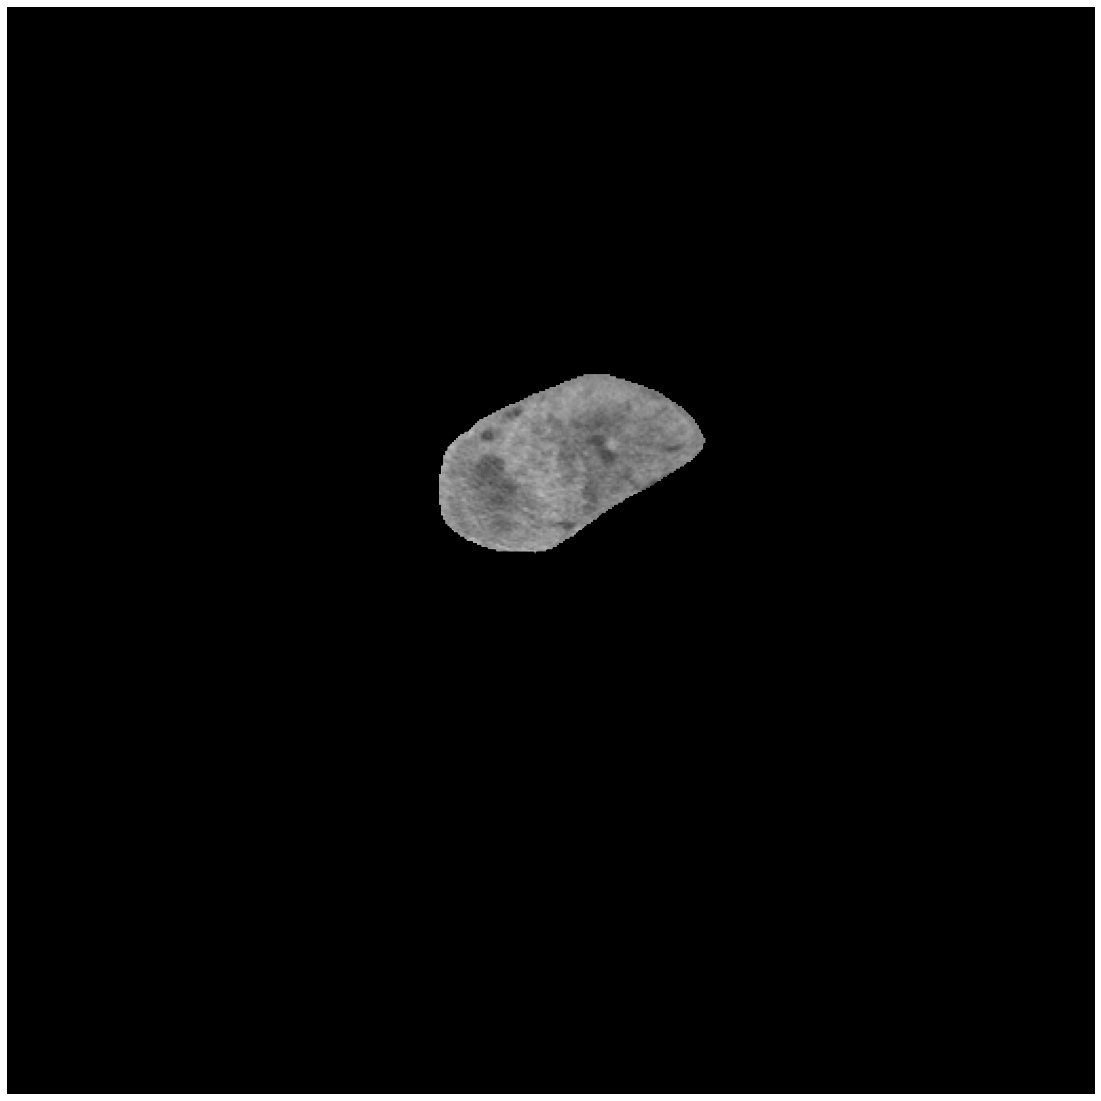

In [31]:
slice_idx = 100
save_name = os.path.join("/media/katy/Data/ICC/HDFS/Figures/", (scout_id + '2d_preprocess_tumor_slice39'))
fig = plt.figure(figsize=(20,20))
plt.imshow(tumor_arr[slice_idx,:,:], cmap='gray', vmin=-100, vmax=300)
plt.axis('off')
# plt.savefig(save_name)

(141, 512, 512)


(-0.5, 511.5, 511.5, -0.5)

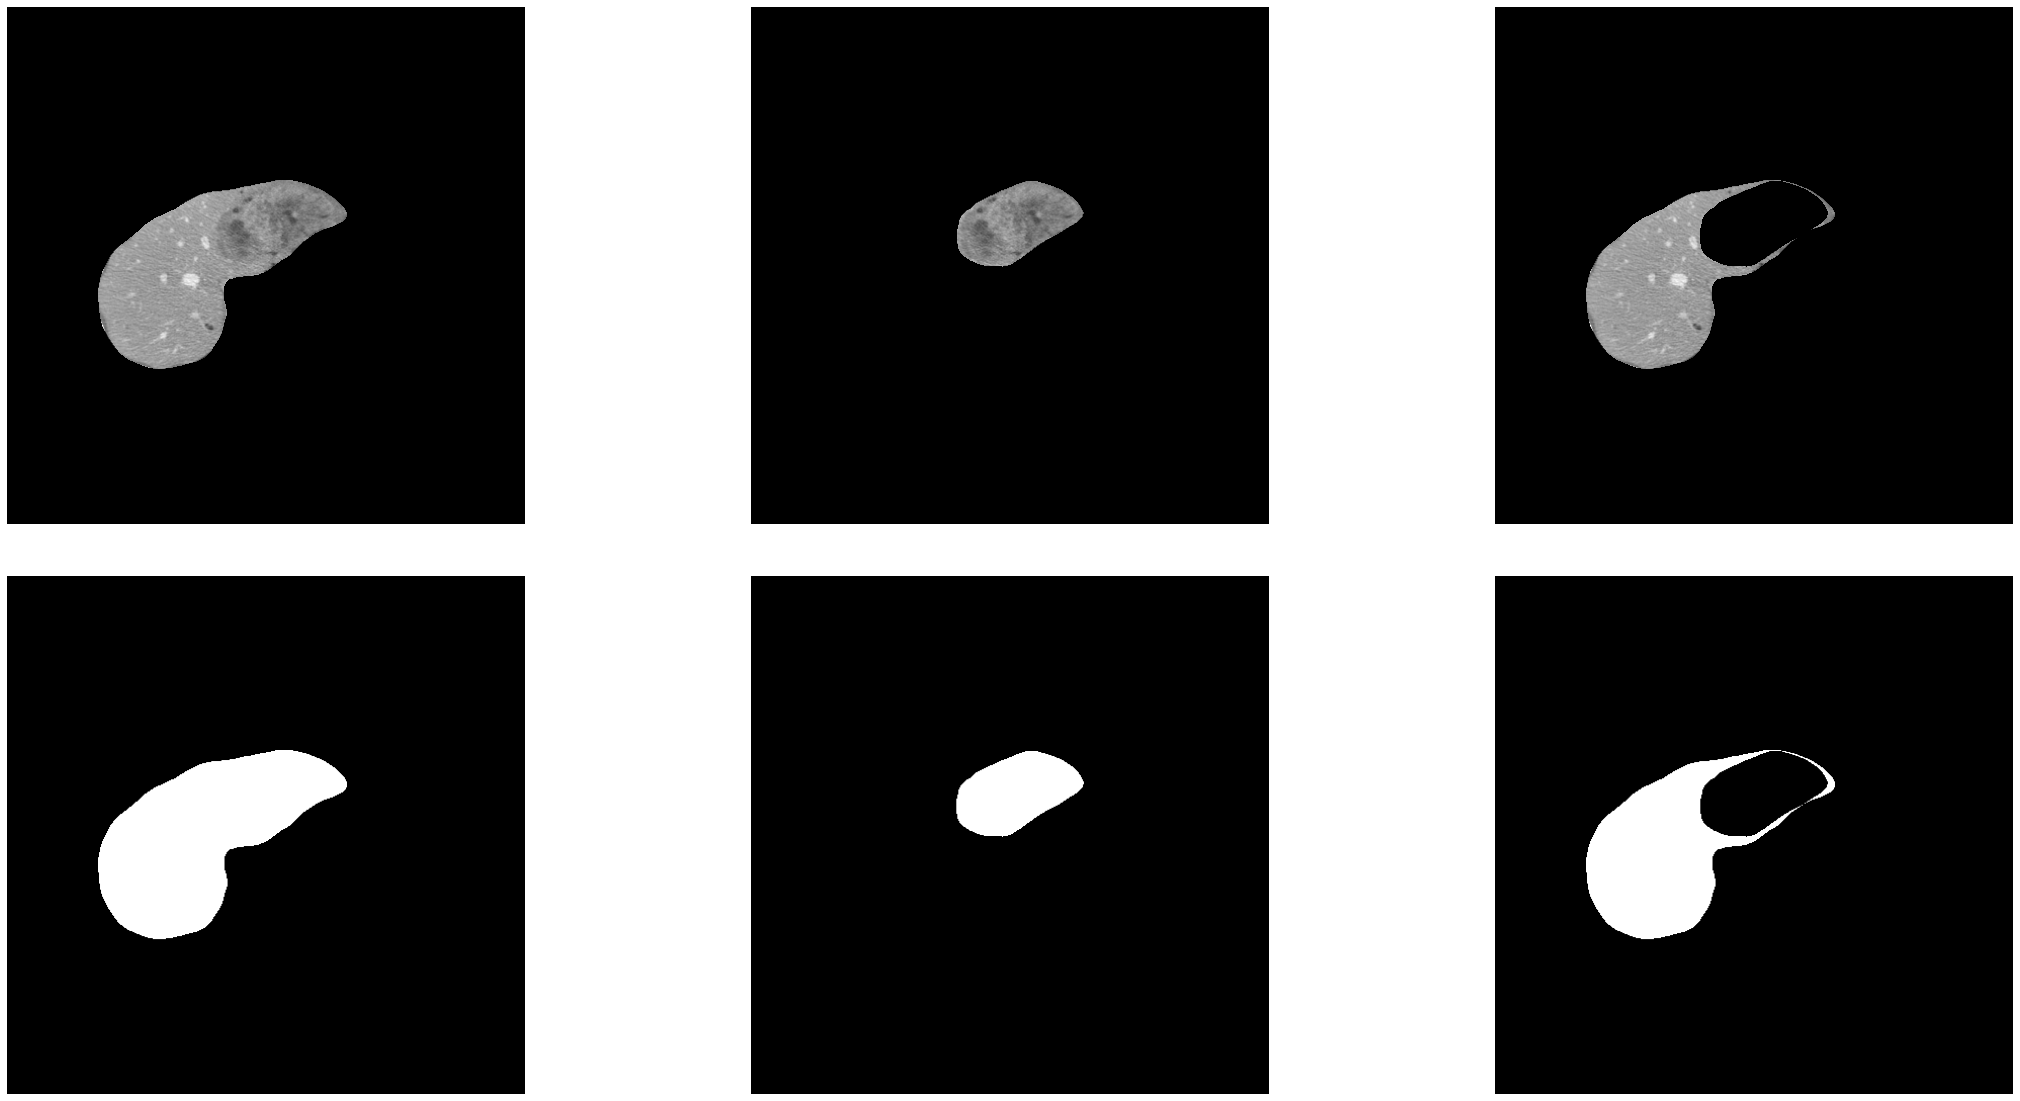

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(40,20))
liverimg_plot = plt.subplot(2, 3, 1)
livermask_plot = plt.subplot(2, 3, 4)
tumorimg_plot = plt.subplot(2, 3, 2)
tumormask_plot = plt.subplot(2, 3, 5)
livernotumor_plot = plt.subplot(2, 3, 3)
livernotumormask_plot = plt.subplot(2, 3, 6)

fig.subplots_adjust(wspace=0, hspace=0.1)

print(notumor_livermask.shape)
slice_idx = 100
liverimg_plot.imshow(liver_arr[slice_idx,:,:], cmap='gray', vmin=-100, vmax=300)
liverimg_plot.axis('off')
livermask_plot.imshow(liver_mask[slice_idx,:,:], cmap='gray')
livermask_plot.axis('off')
tumorimg_plot.imshow(tumor_arr[slice_idx,:,:], cmap='gray', vmin=-100, vmax=300)
tumorimg_plot.axis('off')
tumormask_plot.imshow(tumor_mask[slice_idx,:,:], cmap='gray')
tumormask_plot.axis('off')
livernotumor_plot.imshow(notumor_liver[slice_idx,:,:], cmap='gray', vmin=-100, vmax=300)
livernotumor_plot.axis('off')
livernotumormask_plot.imshow(notumor_livermask[slice_idx,:,:], cmap='gray')
livernotumormask_plot.axis('off')

In [53]:
# Convert no-tumor liver image and mask back to sitk.Image type for feature extraction
liver_image = sitk.GetImageFromArray(notumor_liver)
liver_mask = sitk.GetImageFromArray(notumor_livermask)
# Set pixels to int type for pyradiomics functions
liver_image = sitk.Cast(liver_image, sitk.sitkInt64)
liver_mask = sitk.Cast(liver_mask, sitk.sitkInt64)

tumor_image = sitk.GetImageFromArray(tumor_arr)
tumor_mask = sitk.GetImageFromArray(tumor_mask)
tumor_image = sitk.Cast(tumor_image, sitk.sitkInt64)
tumor_mask = sitk.Cast(tumor_mask, sitk.sitkInt64)

In [38]:
print(tumor_mask.GetSize())
print(tumor_image.GetSize())

(512, 512, 54)
(512, 512, 54)


# Preprocess the image
Following https://github.com/AIM-Harvard/pyradiomics/blob/master/notebooks/helloFeatureClass.ipynb

#### Extraction settings and resampling

In [54]:
settings = {}
settings['resampledPixelSpacing'] = [1, 1, 1]
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

print("Before resampling: ", tumor_image.GetSize())

interpolator = settings.get('interpolator')
# Removes slices with no/few image pixels
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
    liver_image, liver_mask = imageoperations.resampleImage(liver_image, liver_mask, **settings)
    tumor_image, tumor_mask = imageoperations.resampleImage(tumor_image, tumor_mask, **settings)


print("After resampling: ", tumor_image.GetSize())

Before resampling:  (512, 512, 54)
After resampling:  (80, 75, 11)


## Calculate features using original image


In [55]:
# Crop image to mask
# bb is bounding box, upon which image and mask are cropped
liver_bb, liver_correctedMask = imageoperations.checkMask(liver_image, liver_mask, label=1)
if liver_correctedMask is not None:
    liver_mask = liver_correctedMask

tumor_bb, tumor_correctedMask = imageoperations.checkMask(tumor_image, tumor_mask, label=1)
if tumor_correctedMask is not None:
    tumor_mask = tumor_correctedMask

liver_croppedImage, liver_croppedMask = imageoperations.cropToTumorMask(liver_image, liver_mask, liver_bb)
tumor_croppedImage, tumor_croppedMask = imageoperations.cropToTumorMask(tumor_image, tumor_mask, tumor_bb)

print("After cropping: ", liver_croppedImage.GetSize())


After cropping:  (222, 242, 34)


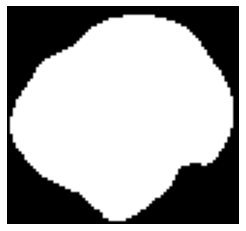

In [63]:
save_name = os.path.join("/media/katy/Data/ICC/HDFS/Figures/", (scout_id + 'tumor_cropped_mask'))

croppedArr = sitk.GetArrayFromImage(tumor_croppedMask)

cropped_slice_idx = 7
fig = plt.figure()#figsize=(40,20))
plt.imshow(croppedArr[cropped_slice_idx,:,:], cmap='gray')#, vmin=-100, vmax=300)
plt.axis('off')
# plt.savefig(save_name)


### Calculate Firstorder features

In [44]:
firstOrderFeatures = firstorder.RadiomicsFirstOrder(croppedImage, croppedMask, **settings)
# firstOrderFeatures.enableAllFeatures()
firstOrderFeatures.enableFeatureByName('Entropy', True)
firstOrderFeatures.enableFeatureByName('Mean', True)
firstOrderFeatures.enableFeatureByName('Variance', True)
firstOrderFeatures.enableFeatureByName('Skewness', True)
firstOrderFeatures.enableFeatureByName('Kurtosis', True)

print("Calculating first order features...")
result = firstOrderFeatures.execute()
print("done")

feats_list = []

print("Calculated first order features: ")
for (key, val) in six.iteritems(result):
    print('    ', key, ':', val)
    feats_list.append(float(val))
    


# Need to take the square root of variance to get standard deviation

Calculating first order features...
done
Calculated first order features: 
     Entropy : 1.5824843222193856
     Mean : 122.19623021596342
     Variance : 329.5935898289986
     Skewness : -1.4349508815305378
     Kurtosis : 16.98905555504112


In [45]:
print(type(key))

<class 'str'>


In [37]:
features_df = pd.DataFrame(columns=['entropy', 'mean', 'variance', 'skewness', 'kurtosis'])
features_df = pd.concat(features_df, )
# features_df

{'Entropy': 1.5824843222193856,
 'Mean': 122.19623021596342,
 'Variance': 329.5935898289986,
 'Skewness': -1.4349508815305378,
 'Kurtosis': 16.98905555504112}

In [ ]:
# Example data used in original tutorial to compare with
# imageName, maskName = radiomics.getTestCase('brain1')

# image = sitk.ReadImage(imageName)
# mask = sitk.ReadImage(maskName)

# image_arr = sitk.GetArrayFromImage(image)
# mask_arr = sitk.GetArrayFromImage(mask)

# print(image.GetSize())
# print(mask.GetSize())
# # plt.imshow(image_arr[15,:,:], cmap='gray')

# image.GetPixelIDTypeAsString()